# Linear and Nonlinear Regression Techniques

In this nb I am going to demonstrate how a linear regression works, its assumptions and diagnostic methods.

Then, I am going to discuss the shortcomings of linear regressions and demonstrate how a decision tree may outperform a linear method.

Finally, some further diagnostic methods and parameter tuning for the decision tree will be shown. 

# Loading the data

I am going to use the kaggle house prices dataset for the demo. Make sure you have a kaggle account and an API token.

Instructions: https://github.com/Kaggle/kaggle-api

To get the data, run `kaggle competitions download -c house-prices-advanced-regression-techniques && unzip house-prices-advanced-regression-techniques.zip`

In [1]:
import pandas as pd
import numpy as np
import datetime
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import TransformedTargetRegressor

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.count().sort_values(), test.count().sort_values()

(PoolQC            7
 MiscFeature      54
 Alley            91
 Fence           281
 FireplaceQu     770
                ... 
 Exterior1st    1460
 RoofMatl       1460
 RoofStyle      1460
 Foundation     1460
 SalePrice      1460
 Length: 81, dtype: int64,
 PoolQC              3
 MiscFeature        51
 Alley             107
 Fence             290
 FireplaceQu       729
                  ... 
 1stFlrSF         1459
 2ndFlrSF         1459
 LowQualFinSF     1459
 FullBath         1459
 SaleCondition    1459
 Length: 80, dtype: int64)

## 81 columns ...

As we discussed in the previous lecture, 81 dimensions is extreme for a linear problem! Whats more, not all of these columns are numerical, some of them will yield even more columns after One Hot Encoding, so our work is cut out for us!

We are going to go through the following steps:

### Part 1 - Linreg
* Analyze the target variable, price
* See if price / m^2 is somewhat more favorable
* pick out the most descriptive features based on correlation
* analyze our regression results
* discuss shortcomings of this approach

### Part 2 - Decision Tree
* build a decision tree to solve the same problem
* compare the 2 results
* discuss overfitting

### Part 3 - Dealing with overfitting
* discuss techniques for dealing with overfitting
* limiting model omplexity
* better feature selection
* using a more advanced technique, RandomForestRegressor!


In [3]:
# first, lets try to find out what the area related features are ...
area_related_features = [
    "GrLivArea",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "TotalBsmtSF",
    "LotArea",
]
# most promising are LotArea and GrLivArea
train["SalePrice_per_GrLivArea"] = train["SalePrice"] / train["GrLivArea"]
train["LotAreaWOLivArea"] = train["LotArea"] - train["GrLivArea"]
print(train[area_related_features + ["SalePrice"]].corr()["SalePrice"])
# the best way to choose, is to plot the relationship between them!
fig = make_subplots(
    1, 2, subplot_titles=("Sale Price vs Living Area", "Sale Price vs LotArea")
)
fig.add_trace(
    go.Scatter(x=train["GrLivArea"], y=train["SalePrice"], mode="markers"), 1, 1
)
fig.add_trace(
    go.Scatter(x=train["TotalBsmtSF"], y=train["SalePrice"], mode="markers"), 1, 2
)

GrLivArea       0.708624
1stFlrSF        0.605852
2ndFlrSF        0.319334
LowQualFinSF   -0.025606
TotalBsmtSF     0.613581
LotArea         0.263843
SalePrice       1.000000
Name: SalePrice, dtype: float64


# Excercise for the reader
Observe the relationship in log space! What do you expect? Better or worse correlation? 

In [4]:
fig = make_subplots(
    2,
    2,
    subplot_titles=(
        "Sale Price Raw",
        "Log Sale Price",
        "Price per m^2",
        "Log price per m^2",
    ),
)
fig.add_trace(
    go.Histogram(x=train["SalePrice"]),
    1,
    1,
)
fig.add_trace(go.Histogram(x=np.log1p(train["SalePrice"])), 1, 2)
fig.add_trace(go.Histogram(x=train["SalePrice_per_GrLivArea"]), 2, 1)
fig.add_trace(go.Histogram(x=np.log1p(train["SalePrice_per_GrLivArea"])), 2, 2)

# px.histogram(train['SalePrice'], title='Sale Price')

In [5]:
# the dataset was gathered over a period of time, lets examine the distribution across time as well!

train["SaleDT"] = train.apply(
    lambda row: datetime.date(row["YrSold"], row["MoSold"], 1), axis=1
)
test["SaleDT"] = train.apply(
    lambda row: datetime.date(row["YrSold"], row["MoSold"], 1), axis=1
)
# data spans 4 years!
# test is not in the future! Why is this a problem?

# Time to come up with a model...

What drives house prices? I think these are the major factors, but you're welcome to come up with your own!
* Living Area
* Lot Area
* House Quality
* Time of Sale
* If there is a Garage
* Dwelling type
* Zone
* Utilities
* NBHood
* When it was built
* Basement Size
* Airconditioning
* Sale Condition

The problem is that most of these are categorical variables! One way to deal wqith them is to use One Hot Encoding!
For a description of other encoders, check out https://contrib.scikit-learn.org/category_encoders/

This is going to add more dimensions though :( Lets start with only
* Living Area
* Lot Area
* House Quality
* House type
* Sale Condition

I also wanted Utilities, but they are all the same!

In [6]:
train_features = ["GrLivArea", "LotArea", "BldgType", "OverallQual", "SaleCondition"]
# no missing here ...
train[train_features]

GrLivArea  LotArea BldgType  OverallQual SaleCondition
0          1710     8450     1Fam            7        Normal
1          1262     9600     1Fam            6        Normal
2          1786    11250     1Fam            7        Normal
3          1717     9550     1Fam            7       Abnorml
4          2198    14260     1Fam            8        Normal
...         ...      ...      ...          ...           ...
1455       1647     7917     1Fam            6        Normal
1456       2073    13175     1Fam            6        Normal
1457       2340     9042     1Fam            7        Normal
1458       1078     9717     1Fam            5        Normal
1459       1256     9937     1Fam            5        Normal

[1460 rows x 5 columns]

In [7]:
train["BldgType"].value_counts()

# mostly single family houses

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

In [8]:
from sklearn.model_selection import cross_val_score
from regression_demo_utilities import create_predictions, setup_regression, eval_model, calculate_metrics_for_pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.base import RegressorMixin



model_pipeline, X_train, X_test, y_train, y_test = setup_regression(
    train, train_features, core_model=DecisionTreeRegressor(), per_m2=True, log_y=False
)

y_train_pred, y_test_pred = create_predictions(model_pipeline, X_train, X_test, per_m2=True)

metrics = {
    **eval_model(y_train, y_train_pred, y_test, y_test_pred, r2_score),
    **eval_model(y_train, y_train_pred, y_test, y_test_pred, mean_squared_error, squared=False),
}
metrics

{'r2_score_train': 0.999984274699008,
 'r2_score_test': 0.5657327484650099,
 'mean_squared_error_train': 301.92237972871396,
 'mean_squared_error_test': 56463.49128956985}

# Aha, the model is completely overfitted!

Without parameters we get an unbounded decision tree which is always going to be overfitted. 

The way to deal with this is to limit the complexity of the model. The 3 most common way to do this for tree-based models is to limit maximum depth, the number of leaves and the splitting criterion. 

In [9]:
params={'max_depth': 8,
       'min_samples_split': 5,
       'max_leaf_nodes': 100}

calculate_metrics_for_pipeline(train, train_features,core_model=DecisionTreeRegressor(**params), log_y=True,
                               per_m2=True)

{'r2_score_train': 0.9014926325688946,
 'r2_score_test': 0.6030738260604551,
 'mean_squared_error_train': 23896.273426582033,
 'mean_squared_error_test': 53981.3892388192}

In [10]:
calculate_metrics_for_pipeline(train, train_features,core_model=DecisionTreeRegressor(**params), log_y=False,
                               per_m2=True)

{'r2_score_train': 0.9158525910976687,
 'r2_score_test': 0.5834931655044668,
 'mean_squared_error_train': 22085.95567645941,
 'mean_squared_error_test': 55296.83242639978}

In [11]:
calculate_metrics_for_pipeline(train, train_features,core_model=DecisionTreeRegressor(**params), log_y=True,
                               per_m2=False)

{'r2_score_train': 0.894949275422496,
 'r2_score_test': 0.6243809501768814,
 'mean_squared_error_train': 24677.16975405471,
 'mean_squared_error_test': 52512.5360961123}

# Regression Trees

In this sectoin we are going to compare some basic regression tree methods: 

* Decision Tree
* Random Forest
* AdaBoost
* Gradient Boosting Tree
* XGBoost

Lets go over the ideas, and parameters to tune. The final objective for this section is to explore hyperparameter tuning and come up with the best model!

## Decision Tree
Source: Statquest for all of this stuff btw

### Gini
Most important concept: Gini impurity. The other concept that is useful is entropy


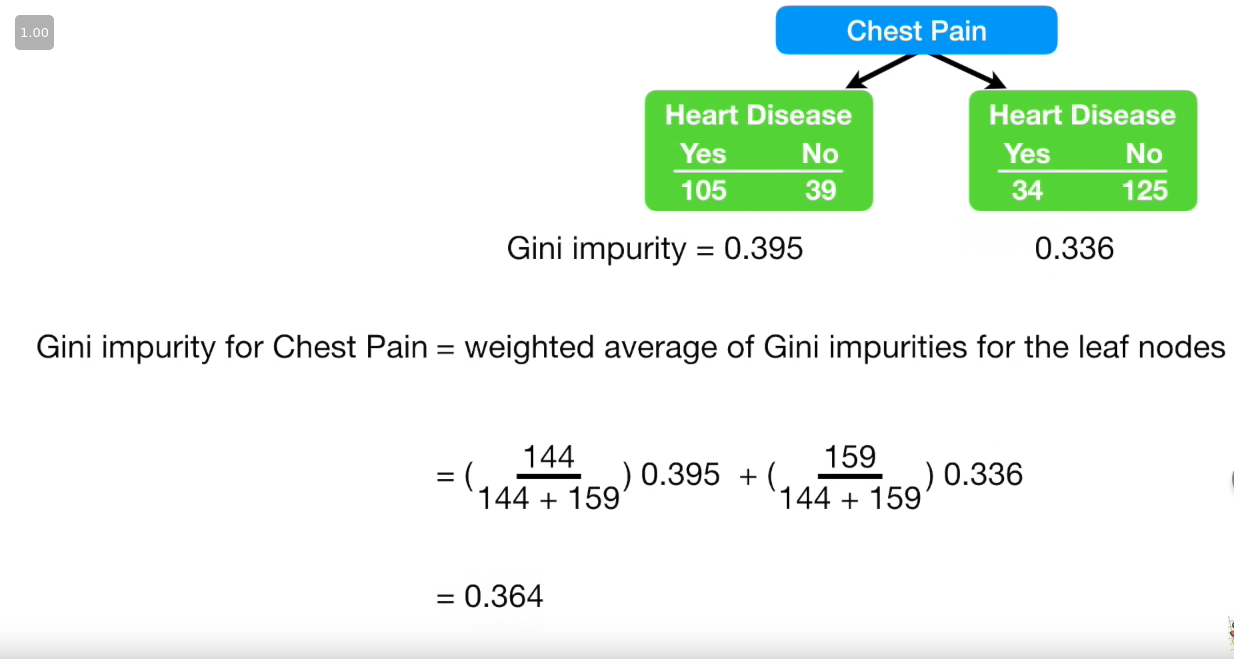

### Entropy

#### Information content
Information content of an event $E$ that has $P(E)$ probability happening
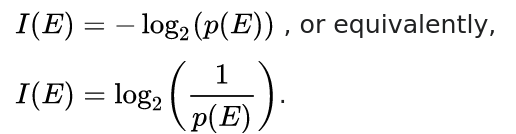

* Coin flip vs Dice roll
* Compression

### Average surprise
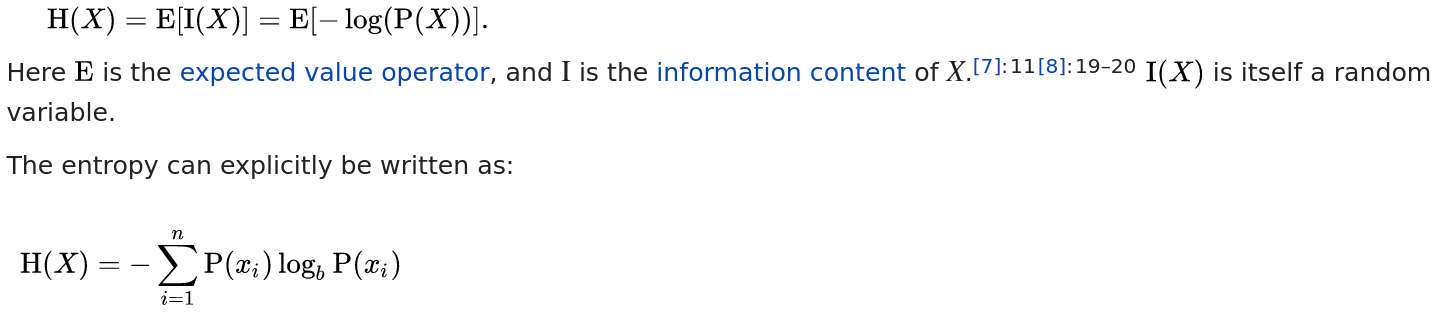

**How does this apply to decision Tree splitting?**

### Why the log face?

$I(p1·p2) = I(p1) + I(p2)$: the information learned from independent events is the sum of the information learned from each event.

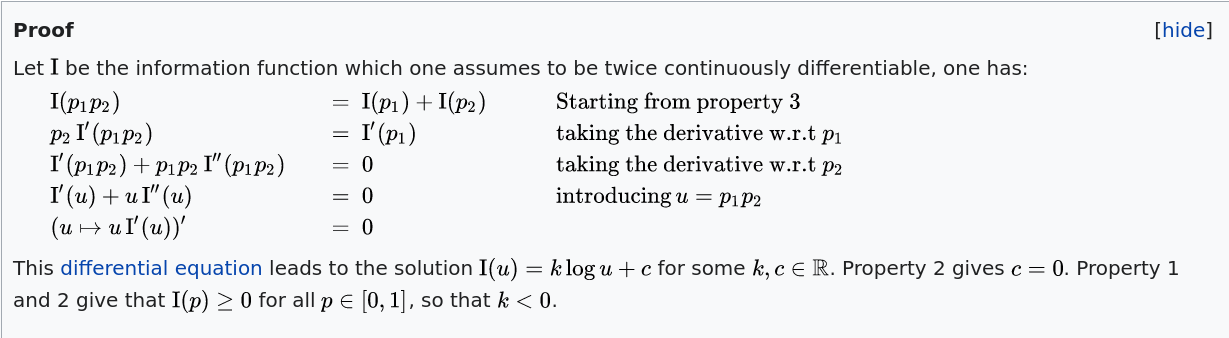

## Random Forest

Decision trees + 
* Bootstrapping --> Sampling weights?
* Bagging
* Regularization


## AdaBoost
A bit different from Random Forest, but it is also
* Bagging
* Weak Learners, almost always stumps

But also adding 
* Amount of say for each tree
* Adjusting sample weights
* Resampling
* This is why it is adapting! ADAboost

## Gradient Boosting Tree

Same as AdaBoost, but:
* not stumps
* tries to predict the residuals
* learning rate --> idea?

## XGBoost
Same as GBM, but: 
* the trees are not the same
* similarity score
* histogram splitting
* gain
* pruning
* lambda
* gamma 

https://stats.stackexchange.com/questions/418687/gamma-parameter-in-xgboost

# How to select the optimal parameters?

### This is called hyperparameter tuning. 
The most basic is called Grid Search: Provide a set of possible parameters, and calculate score for all possible combinations (Certesian product). 

# Q: How could we improve that? 
There are packages of course, but the main idea is Bayesian parameter optimization

Bayes: Express a level of belief in a fact

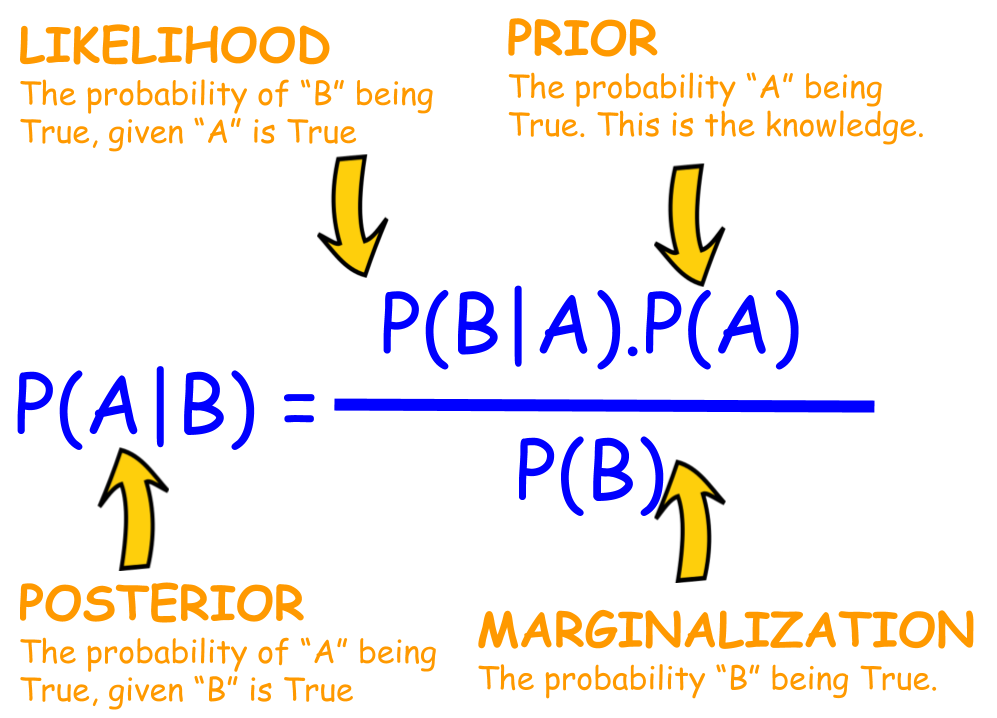


# Monty Hall Bayesian reasoning
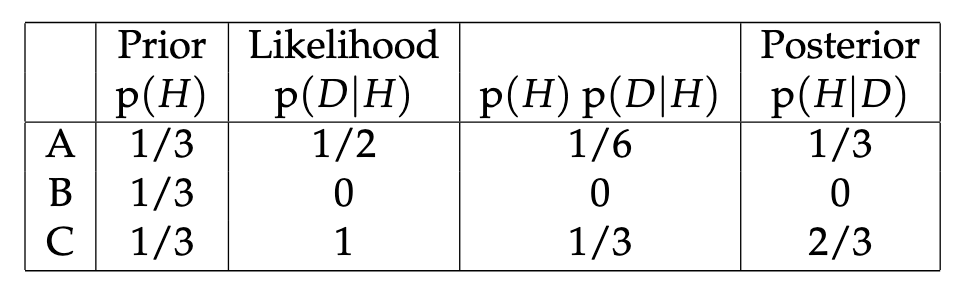


# Bayesian hyperparameter optimization

## Example: Losing your phone

## Example: Coin toss
https://towardsdatascience.com/what-is-bayesian-inference-4eda9f9e20a6

We have a coin, we can flip it, and we want to decide if it is fair!

Frequentist approach: Hypothesis testing, Maximum Likelihood Estimation

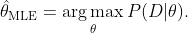

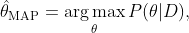

Bayesian approach: Calculate the posterior based on the sample!
https://machinelearningmastery.com/what-is-bayesian-optimization/


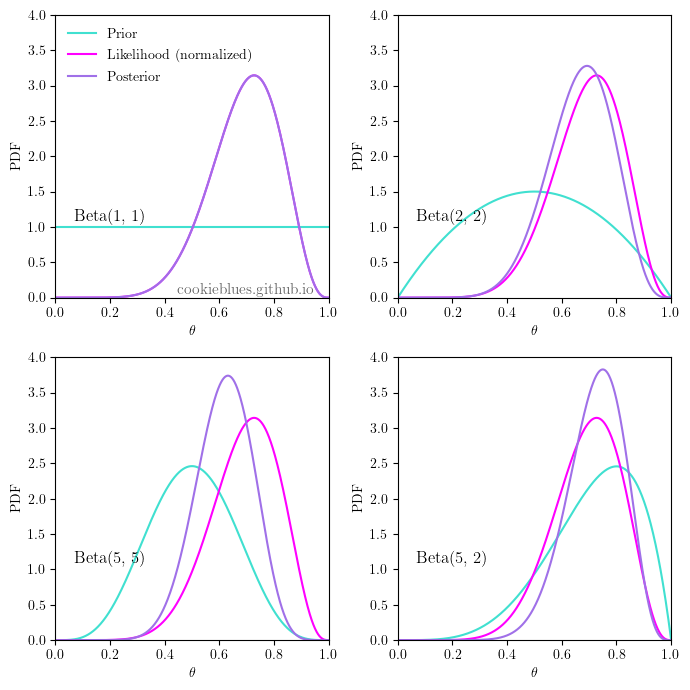

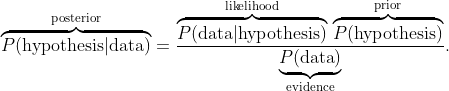

# Optimization

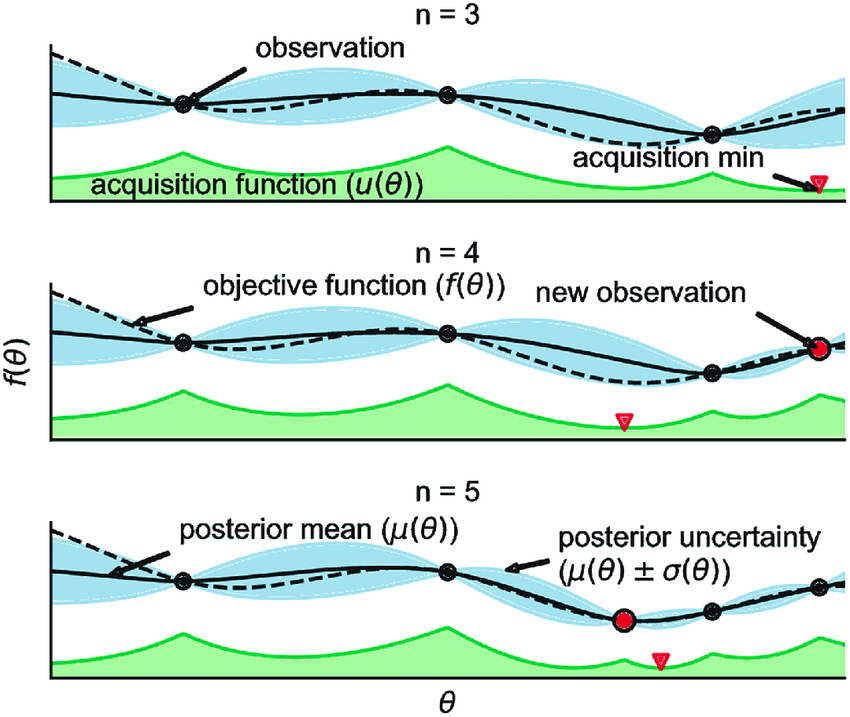

# Bayesian optimization on a different domain: Combinatorial optimization

## Metropolis - Hastings Algorithm
**Co-authored by Edward Teller(!)**
**Originally proposed to generate sample states of a thermodynamic system**

We want a way to sample a very difficult probability distribution, provided that we have a $f(x)$ that is proportional to $P(x)$, otherwise known as a likelihood.

Given some initial state, we take a new sample, and decide to accept or reject it. 

**Markov Chain Monte Carlo**

**vs adaptive rejection sampling**

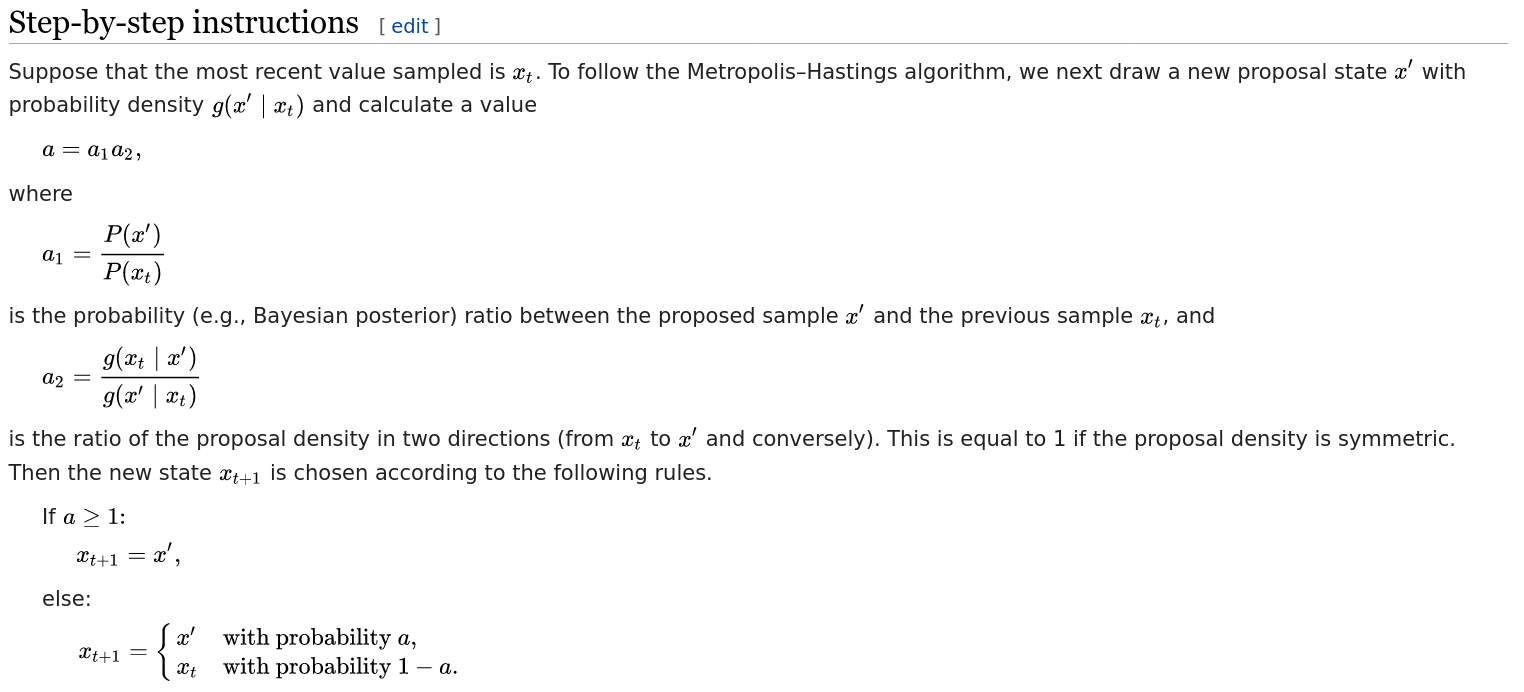




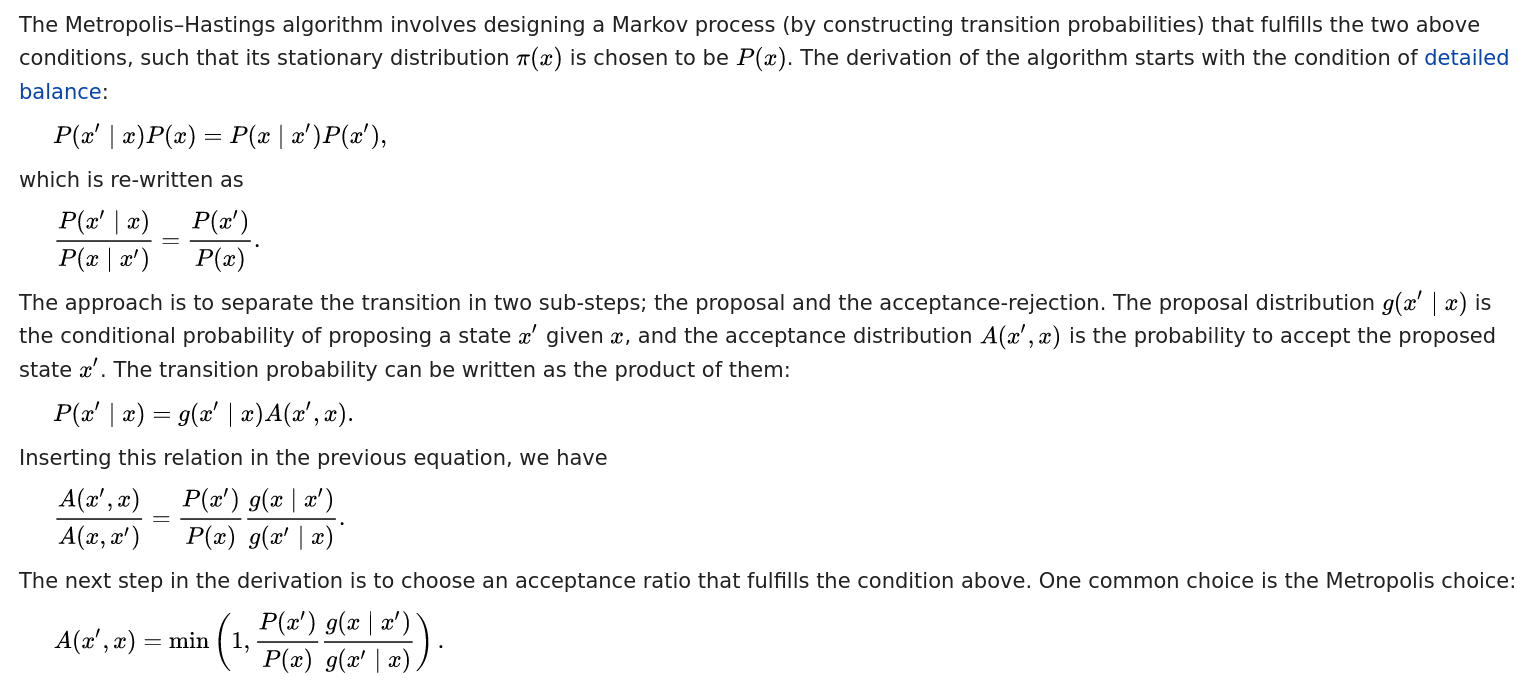
### Optimization usage:

We want to find a global maximum of a function!
### Simulated Annealling

https://en.wikipedia.org/wiki/Simulated_annealing

## Finally, bayesian hyperparameter optimization!

Source: https://towardsdatascience.com/bayesian-optimization-with-python-85c66df711ec

In [12]:
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

In [13]:
from xgboost import XGBRegressor

In [14]:
from hyperopt import hp


In [156]:
base_search_space = {
    "n_estimators": hp.randint("n_estimators", 200, 1000),
    "learning_rate": hp.loguniform("learning_rate", -5, 0),
    # "gamma": hp.loguniform('gamma',0.1, 1),
    # "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
}
rf_search_space = {
    "n_estimators": hp.randint("n_estimators", 20, 400),
    "min_samples_split": hp.randint("min_samples_split", 2, 30),
    "min_samples_leaf": hp.randint("min_samples_leaf", 1, 30),
    "max_depth": hp.randint("max_depth", 1, 20),
        "criterion": hp.choice("criterion", ["friedman_mse", "squared_error"]),
    "max_features": hp.choice('max_features',['auto','sqrt','log2']),
    "min_impurity_decrease": hp.loguniform("min_impurity_decrease",-5,1),
    "ccp_alpha": hp.loguniform("ccp_alpha",-5,1),
    "oob_score": hp.choice('oob_score',[True,False]),
    "max_samples":hp.uniform("max_samples",0,1)

}
gbm_search_space = {
    "criterion": hp.choice("criterion", ["friedman_mse", "squared_error"]),
    "min_samples_split": hp.randint("min_samples_split", 2, 10),
    "min_samples_leaf": hp.randint("min_samples_leaf", 2, 10),
    "max_depth": hp.randint("max_depth", 1, 4),
    "subsample": hp.uniform("subsample", 0.5, 1),
    "alpha": hp.loguniform("alpha", -2, 0),
}
search_space = {**base_search_space, **gbm_search_space}
import importlib as imp
import regression_demo_utilities as rd

imp.reload(rd)

<module 'regression_demo_utilities' from '/home/karpatika/RAJK/rajk_machine_learning_course/house_prices/regression_demo_utilities.py'>

In [181]:
categorical_cols = train.select_dtypes(exclude=np.number).nunique() < 5
categorical_features = list(categorical_cols[categorical_cols].index)

In [182]:
categorical_features

['Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LandSlope',
 'ExterQual',
 'CentralAir',
 'KitchenQual',
 'GarageFinish',
 'PavedDrive',
 'PoolQC']

In [183]:
numerical_features = ['MSSubClass','LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'LotAreaWOLivArea']
train_features=categorical_features + numerical_features

In [184]:
train[categorical_features] = train[categorical_features].astype(str).fillna("UNKNOWN")
train[numerical_features] = train[numerical_features].fillna(0)



In [185]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
def black_box_fn(search_space_point):
    res = rd.calculate_metrics_for_pipeline(
        train,
        train_features,
        core_model=RandomForestRegressor(**search_space_point),
        log_y=False,
        per_m2=True,
    )
    return res["mean_squared_error_test"]

In [186]:
best_params = fmin(
  fn=black_box_fn,
  space={**rf_search_space},
  algo=tpe.suggest,
  max_evals=20)

100%|██████████| 20/20 [00:09<00:00,  2.04trial/s, best loss: 30145.461215810545]


In [187]:
best_params

{'ccp_alpha': 0.6051692175963014,
 'criterion': 0,
 'max_depth': 18,
 'max_features': 0,
 'max_samples': 0.1098219006609753,
 'min_impurity_decrease': 0.1670588566546621,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 334,
 'oob_score': 1}

In [193]:
best_params['criterion']='squared_error'
best_params['max_features']='auto'
best_params['oob_score']=False

In [194]:
model_pipeline, X_train, X_test, y_train, y_test = rd.setup_regression(
    train,
    train_features,
    RandomForestRegressor(**best_params),
    per_m2=True,
    log_y=False,
)
y_train_pred, y_test_pred = create_predictions(
        model_pipeline, X_train, X_test, per_m2=True
    )
eval_model(
            y_train,
            y_train_pred,
            y_test,
            y_test_pred,
            mean_squared_error,
            squared=False,
        )

{'mean_squared_error_train': 39974.07650820454,
 'mean_squared_error_test': 29916.46415575198}

In [195]:
gbt=model_pipeline.steps[1][1]
#model_pipeline.steps[0][1].transform(reg[1]).shape

In [196]:
model_pipeline.steps[0][1].get_feature_names_out()

array(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'LotAreaWOLivArea', 'Street_Grvl',
       'Street_Pave', 'Alley_Grvl', 'Alley_Pave', 'Alley_nan',
       'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg',
       'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low',
       'LandContour_Lvl', 'Utilities_AllPub', 'Utilities_NoSeWa',
       'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev', 'ExterQual_Ex',
       'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA', 'CentralA

In [197]:
pd.DataFrame(
    gbt.feature_importances_,
    index=model_pipeline.steps[0][1].get_feature_names_out(),
    columns=["feature_importance"],
).sort_values("feature_importance", ascending=False).head(30)

feature_importance
YearBuilt                   0.204854
2ndFlrSF                    0.116807
BsmtFinSF1                  0.077558
YearRemodAdd                0.073489
GarageYrBlt                 0.072947
TotalBsmtSF                 0.052756
GrLivArea                   0.050114
OverallQual                 0.046332
MSSubClass                  0.024319
GarageArea                  0.023257
1stFlrSF                    0.022220
TotRmsAbvGrd                0.020926
BsmtUnfSF                   0.018236
OverallCond                 0.016360
BedroomAbvGr                0.014654
LotAreaWOLivArea            0.010517
OpenPorchSF                 0.010435
MasVnrArea                  0.010357
KitchenQual_Ex              0.010222
MoSold                      0.010008
LotFrontage                 0.009805
LotArea                     0.009277
KitchenAbvGr                0.008681
GarageCars                  0.008000
BsmtFullBath                0.007395
ExterQual_Ex                0.006976
WoodDeckSF                  0.006865
HalfBath                    0.006351
YrSold                      0.005093
ExterQual_Gd                0.005015

# Next Steps: Diagnostics!

Lets see the relationship between YearBuilt and the target variable!



In [198]:
fig = make_subplots(
    1, 2, subplot_titles=("YearBuilt vs price", "Fitted vs Actual Test set")
)
fig.add_trace(
    go.Scatter(x=train["YearBuilt"], y=train["SalePrice_per_GrLivArea"], mode="markers"), 1, 1
)
fig.add_trace(
    go.Scatter(x=y_test, y=y_test_pred, mode="markers"), 1, 2
)